In [8]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
from tqdm import tqdm

In [89]:
%load_ext autoreload
%autoreload 2


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
data = []
with gzip.open('../Downloads/All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [15]:
cur = pd.DataFrame(data
                  )

In [16]:
overall = cur.overall
text = cur.reviewText

In [17]:
beauty = pd.DataFrame()
beauty["overall"] = overall
beauty["text"] = text

In [51]:
beauty.loc[beauty["overall"] < 3, "overall"] = 1
beauty.loc[beauty["overall"] > 3, "overall"] = 2

In [11]:
len(beauty.iloc[-190000:])

190000

In [20]:
beauty = beauty.drop(beauty[beauty["overall"] == 3].index)

In [21]:
test = beauty.iloc[-190000:]

In [22]:
test.loc[test["overall"] < 3, "overall"] = 1
test.loc[test["overall"] > 3, "overall"] = 2

/Users/liu_zizhou/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/liu_zizhou/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [52]:
beauty.overall.value_counts()
#test=test.drop(test["overall"] == 3)

1.0    210517
2.0    131273
Name: overall, dtype: int64

In [62]:
test_neg = beauty[beauty["overall"] == 1].iloc[-95000:]
test_pos = beauty[beauty["overall"] == 2].iloc[-95000:]

In [64]:
train_neg=test_neg.sample(frac=0.8,random_state=200)
train_pos=test_pos.sample(frac=0.8,random_state=200)
test_neg = test_neg.drop(train_neg.index)
test_pos = test_pos.drop(train_pos.index)

In [65]:
test = pd.concat([test_neg,test_pos]).sample(frac = 1,random_state=200)
train = pd.concat([train_neg,train_pos]).sample(frac = 1,random_state=200)

In [24]:
# train=test.sample(frac=0.8,random_state=200) #random state is a seed value
# test=test.drop(train.index)

In [67]:
test.overall.value_counts()

2.0    19000
1.0    19000
Name: overall, dtype: int64

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
Y_train=train['overall'].values
Y_test=test['overall'].values
     
# GET FEATURES
X_train,X_test,feature_transformer=extract_features("text",train,test)

In [69]:
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(X_train,Y_train)

[LibLinear]

In [44]:
def extract_features(field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    #logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        #print(training_data[field])
        cv.fit_transform(training_data[field].values.astype('U'))
        
        train_feature_set=cv.transform(training_data[field].values.astype('U'))
        test_feature_set=cv.transform(testing_data[field].values.astype('U'))
        
        return train_feature_set,test_feature_set,cv

In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [1,2]
target_names = ['negative','positive']
def report(true, predicted, labels = None, target_names = None):
    print(classification_report(true,predicted,labels = labels, target_names = target_names,digits=4))
    cm = confusion_matrix(true,predicted,labels = labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot()
    plt.show()

In [76]:
!pip install transformers

In [80]:
test.to_csv("test.csv")
train.to_csv("train.csv")

In [79]:
## PyTorch Transformer
from transformers import RobertaModel, RobertaTokenizer
from transformers import RobertaForSequenceClassification, RobertaConfig
config = RobertaConfig.from_pretrained('roberta-base')
config.num_labels = 2
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification(config)

ModuleNotFoundError: No module named 'transformers'

In [ ]:
def prepare_features(seq_1, max_seq_length = 300, 
             zero_pad = False, include_CLS_token = True, include_SEP_token = True):
    ## Tokenzine Input
    tokens_a = tokenizer.tokenize(seq_1)

    ## Truncate
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]
    ## Initialize Tokens
    tokens = []
    if include_CLS_token:
        tokens.append(tokenizer.cls_token)
    ## Add Tokens and separators
    for token in tokens_a:
        tokens.append(token)

    if include_SEP_token:
        tokens.append(tokenizer.sep_token)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    ## Input Mask 
    input_mask = [1] * len(input_ids)
    ## Zero-pad sequence lenght
    if zero_pad:
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
    return torch.tensor(input_ids).unsqueeze(0), input_mask

In [ ]:
class Intents(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):
        text = self.data.text[index]
        y = self.data.label[index]
        X, _  = prepare_features(text)
        return X, y
    
    def __len__(self):
        return self.len

In [70]:
predictions=model.predict(X_test)

              precision    recall  f1-score   support

         1.0     0.6624    0.7516    0.7042     19000
         2.0     0.7129    0.6170    0.6615     19000

    accuracy                         0.6843     38000
   macro avg     0.6877    0.6843    0.6829     38000
weighted avg     0.6877    0.6843    0.6829     38000



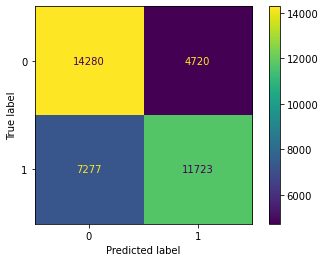

None


In [73]:
print(report(Y_test, predictions))

In [34]:
import pandas as pd


chunks = pd.read_json("Electronics.json", lines=True, chunksize = 1000)


In [35]:
limit = 20700
count = 0
for c in tqdm(chunks):
    if count < limit:
        count += 1
        continue
    break

20700it [03:15, 105.64it/s]


In [36]:
data = pd.DataFrame()
for c in tqdm(chunks):
    
    data = data.append(c)
    

294it [00:12, 23.37it/s]


In [17]:
from datetime import datetime

In [40]:
len(data)

293353

In [38]:
onestar = data.loc[data["overall"] == 1]

In [39]:
twostar = data.loc[data["overall"] == 2]
threestar = data.loc[data["overall"] == 3]

fourstar = data.loc[data["overall"] == 4]
fivestar = data.loc[data["overall"] == 5]

In [100]:
len(data.iloc[-60001 : -1])

60000

In [41]:
cur = data.iloc[-60001 : -1]

In [42]:
len(cur)

60000

In [46]:
train=cur.sample(frac=0.8,random_state=200) #random state is a seed value
test=cur.drop(train.index)

In [23]:
apple = []

In [33]:
cur

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image
20934352,4,True,"09 20, 2018",A3G95RJJ51WD8H,B01G4SSSQ4,Omar Cortina,Charges without issues. Works great with my HP...,Works great for my HP Revolve 810,1537401600,NaN,NaN,[https://images-na.ssl-images-amazon.com/image...
20934353,5,True,"09 20, 2018",A4OOB8NOIYJWF,B01G4SSSQ4,Huascar G.,"Fast Shipping and excelent Product Quality, Th...","Fast Shipping and excelent Product Quality, Th...",1537401600,NaN,NaN,NaN
20934354,1,True,"09 20, 2018",A2X416AYFNXNUV,B01G4SSSQ4,John De Mott,"Didn't charge laptop, feels incredibly light a...","Sparked when I plugged in, didn't charge",1537401600,NaN,NaN,NaN
20934355,5,True,"09 11, 2018",A11C3NWD00G18B,B01G4SSSQ4,Jenny Geier,it works,it works,1536624000,NaN,NaN,NaN
20934356,5,True,"08 29, 2018",A3L8IABFY9RHYL,B01G4SSSQ4,L.M.P. Downes,I ordered the power supply adapter so that I d...,"It Works, Was Reasonably Priced and Arrived Pr...",1535500800,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20994347,2,True,"07 6, 2017",ANWNYOOYLACMT,B01HJF704M,Scott,Was advertised for all Operating Systems. Not ...,Shifty Eyes...,1499299200,NaN,NaN,NaN
20994348,1,True,"04 29, 2017",A1RH0C7YHWZQER,B01HJF704M,Randy Garmire,"Had it 1 day and it quit working, will be retu...",JUNK,1493424000,NaN,NaN,NaN
20994349,5,True,"04 17, 2017",A2955VBJEJZ4S,B01HJF704M,BJN,Received item in 2 days. Product worked as adv...,Instructions easy and clear,1492387200,NaN,NaN,NaN
20994350,5,True,"03 31, 2017",A1FGCIRPRNZWD5,B01HJF704M,Brando,I have it plugged into a usb extension on my g...,Works well enough..,1490918400,NaN,NaN,NaN


In [32]:
saved

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,vote,image
19301000,1,True,"03 27, 2016",A97BEF1IPTMJU,B00F3T2M0E,Amazon Customer,Arrived earlier than expected. Works perfectly,Five Stars,1459036800,NaN,NaN,NaN
19301001,1,True,"03 22, 2016",A323CYTXKNMO6L,B00F3T2M0E,Amazon Customer,Stopped working after only a few days.,Two Stars,1458604800,NaN,NaN,NaN
19301002,1,True,"03 19, 2015",A2HOINCTFDVWBU,B006FRIWRK,GBEAN,Functionally very good.\nThe rubber pad will d...,Functionally very good. The rubber pad will de...,1426723200,NaN,NaN,NaN
19301003,1,True,"02 12, 2018",A1PFLPMEKOKQ35,B00F3T2FQA,UNKNOWN,perfect,Five Stars,1518393600,NaN,NaN,NaN
19301004,1,True,"03 1, 2016",A3DLU1E85CTF7X,B00F3T2FQA,DH,Works,Five Stars,1456790400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20994348,1,True,"04 29, 2017",A1RH0C7YHWZQER,B01HJF704M,Randy Garmire,"Had it 1 day and it quit working, will be retu...",JUNK,1493424000,NaN,NaN,NaN
20994349,1,True,"04 17, 2017",A2955VBJEJZ4S,B01HJF704M,BJN,Received item in 2 days. Product worked as adv...,Instructions easy and clear,1492387200,NaN,NaN,NaN
20994350,1,True,"03 31, 2017",A1FGCIRPRNZWD5,B01HJF704M,Brando,I have it plugged into a usb extension on my g...,Works well enough..,1490918400,NaN,NaN,NaN
20994351,1,True,"02 16, 2017",AOEG7L8HI8DXJ,B01HJF704M,Mack,Fast delivery product was simple to use,Good product,1487203200,NaN,NaN,NaN


In [43]:
cur.loc[cur["overall"] < 3, "overall"] = 1
cur.loc[cur["overall"] > 3, "overall"] = 2


In [110]:
cur

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
20934352,2,True,"09 20, 2018",A3G95RJJ51WD8H,B01G4SSSQ4,Omar Cortina,Charges without issues. Works great with my HP...,Works great for my HP Revolve 810,1537401600,NaN,NaN,[https://images-na.ssl-images-amazon.com/image...
20934353,2,True,"09 20, 2018",A4OOB8NOIYJWF,B01G4SSSQ4,Huascar G.,"Fast Shipping and excelent Product Quality, Th...","Fast Shipping and excelent Product Quality, Th...",1537401600,NaN,NaN,NaN
20934354,1,True,"09 20, 2018",A2X416AYFNXNUV,B01G4SSSQ4,John De Mott,"Didn't charge laptop, feels incredibly light a...","Sparked when I plugged in, didn't charge",1537401600,NaN,NaN,NaN
20934355,2,True,"09 11, 2018",A11C3NWD00G18B,B01G4SSSQ4,Jenny Geier,it works,it works,1536624000,NaN,NaN,NaN
20934356,2,True,"08 29, 2018",A3L8IABFY9RHYL,B01G4SSSQ4,L.M.P. Downes,I ordered the power supply adapter so that I d...,"It Works, Was Reasonably Priced and Arrived Pr...",1535500800,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20994347,1,True,"07 6, 2017",ANWNYOOYLACMT,B01HJF704M,Scott,Was advertised for all Operating Systems. Not ...,Shifty Eyes...,1499299200,NaN,NaN,NaN
20994348,1,True,"04 29, 2017",A1RH0C7YHWZQER,B01HJF704M,Randy Garmire,"Had it 1 day and it quit working, will be retu...",JUNK,1493424000,NaN,NaN,NaN
20994349,2,True,"04 17, 2017",A2955VBJEJZ4S,B01HJF704M,BJN,Received item in 2 days. Product worked as adv...,Instructions easy and clear,1492387200,NaN,NaN,NaN
20994350,2,True,"03 31, 2017",A1FGCIRPRNZWD5,B01HJF704M,Brando,I have it plugged into a usb extension on my g...,Works well enough..,1490918400,NaN,NaN,NaN


In [117]:
test = pd.DataFrame(zip(cur.overall[:5],cur.reviewText[:5]))
test.columns = ["rating","text"]

In [118]:
test

,rating,text
0,2,Charges without issues. Works great with my HP...
1,2,"Fast Shipping and excelent Product Quality, Th..."
2,1,"Didn't charge laptop, feels incredibly light a..."
3,2,it works
4,2,I ordered the power supply adapter so that I d...


In [186]:
import torch
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaForMaskedLM
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForMaskedLM.from_pretrained("roberta-base")

In [187]:
model.save_pretrained("./")

In [192]:
model = RobertaForMaskedLM.from_pretrained("model/")

In [309]:
sum_probs = []
for i in test[test["rating"] ==1].text:
    print(i)
    prompt = generate_prompt("aspect",i,label = 'bad')
    logits = generate_logits(prompt,tokenizer,model)
    print(logits)
    probabilities = F.softmax(logits,dim=-1)[0]
    print(probabilities)
    sum_probs.append(probabilities)
    print(sum_probs)
probability = torch.sum(torch.stack(sum_probs),dim=0)
verbalizers = [quality,general,price,design,service]
aspects = ["quality","general","price","design","service"]

Didn't charge laptop, feels incredibly light and shoddy
tensor([[ 2.0909, -4.3024,  8.5324,  ..., -6.0261, -6.2077,  2.8349]])
tensor([8.3754e-06, 1.4009e-08, 5.2544e-03,  ..., 2.4994e-09, 2.0844e-09,
        1.7624e-05])
[tensor([8.3754e-06, 1.4009e-08, 5.2544e-03,  ..., 2.4994e-09, 2.0844e-09,
        1.7624e-05])]


In [310]:
import numpy as np
def sort_tuple(tup): 
  
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of 
    # sublist lambda has been used 
    tup.sort(key = lambda x: x[1]) 
    return tup 
def conclude(results,aspects,overall = "good"):
    best_aspect = np.argmax([result[-1][1] for result in results])
    Top3 = [result[-1] for result in results]
    print(Top3)
    Top3 = [i[0] for i in sort_tuple(Top3)[-3:]]
    if overall == "good":
        return f"Overall, your product's best aspect is {aspects[best_aspect]},people love these features with ascending likeness: {Top3}"
    else:
        return f"Overall, your product's not-so-good aspect is {aspects[best_aspect]},people didn't like these features with ascending dislikeness: {Top3}"


In [307]:

results = [sort_logit(verbalizer,probability) for verbalizer in verbalizers]
results
final_text = conclude(results,aspects,)

[('quality', tensor(0.0026)), ('bad', tensor(0.0047)), ('price', tensor(0.0542)), ('design', tensor(0.0027)), ('packaging', tensor(0.0014))]


In [308]:
final_text

"Overall, your product's best aspect is price,people love these features: ['design', 'bad', 'price']"

In [315]:
scores = []
for text in test.text:
    score = []
    for i in verbalizers:
        prompt = generate_prompt("score",text,target = i)
        logits = generate_logits(prompt,tokenizer,model)
        score.append(generate_rating(logits[0]))
    scores.append(score)
scores = np.array(scores).sum(axis=0)/10

In [317]:
print(scores)

[1.91463558 2.06313808 1.84642285 1.571164   1.97903387]


In [205]:
a = [1,2]
b = [3,4]

In [212]:
for i in zip(a,b):
    print(i)

(1, 3)
(2, 4)


In [208]:
print(i)

In [179]:
import plotly.express as px
import pandas as pd



In [184]:
import plotly.express as px
graph = pd.DataFrame(dict(
    r=scores,
    theta=aspects))
fig = px.line_polar(graph, r='r', theta='theta', line_close=True,range_r = (0,5))
fig.update_traces(fill='toself')
fig.write_html("test.html")

In [173]:
scores

[2.4422880932688713,
 3.4038644582033157,
 3.348674051463604,
 1.9162903651595116,
 3.234288863837719]

In [136]:
final_text

"Overall, your product's best aspect is quality,people love these features: ['material', 'product', 'quality']"

In [137]:
logits

tensor([[37.8437, -3.5226, 45.9163,  ...,  0.2375,  1.6046, 25.9030]])

In [152]:
ratings = ['great','good','average','bad','terrible']
rating_indices = [verbalize(i)[0] for i in ratings]
rating_scores = np.array([5,4,3,2,1])

In [153]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x),axis = 0)

In [151]:
np.array([1,2]) * np.array([3,4])

array([3, 8])

In [156]:
def generate_rating(logits):
    result = []
    for index in rating_indices:
        result.append(logits[index])
    return np.sum(softmax(result) * rating_scores)

In [157]:
generate_rating(logits[0])

3.825812154565938

In [33]:
quality = ['product','quality','expectation',
           'material','broke','flaw','advertised',
           'durable','year']
general = ['overall','great','good','perfect',
           'bad','complaints','recommended',
           'love','awesome']
price = ['price','cheap','expensive','value',
         'afford','cost']
design = ['looks','small','large','beautiful',
          'design','disgusting']
service = ['service','replacement','quick',
           'return','delivery','packaging']

In [34]:
aspects = [quality,general,price,comments,experience]
verbalizers =["quality","general","price","comments","experience"]

In [123]:
def generate_logits(prompt,tokenizer,model):
    inputs = tokenizer(prompt,return_tensors="pt",padding=True)
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
    mask_index = (inputs.input_ids[0] == tokenizer.mask_token_id).nonzero(as_tuple=False)
    predicted_logit = logits[0][mask_index][0]
    #print(predicted_logit)
    return predicted_logit

In [289]:
def generate_prompt(usage, text,mask="<mask>",label = "good",target = "quality"):
    prompts = {
            "aspect": {
                "good" : f"{text}. Overall, customer like this product because {mask}",
                "bad" : f"{text}. Overall, customer hate this product because {mask}.",
            },
                    
            "score":{
                label: f"{text}.Overall, this product's {target} is {mask}.",
            }
    }
    return prompts[usage][label]

In [169]:
generate_prompt("score",testtext,target=quality)

"Arrived on time. I set them up and they worked perfect for about 5 mins before one of them started sizzling and popping. the bulb went out. I purchased on amazon so i called amazon. they couldn't do anything. Safstar says it can be up to 3 business days before i get contacted to get a return started.\nUpdate: I did move from 1 star to 3 stars. it did take 3 days for them to get back to me about a refund. But, they did issued a hassle free refund.\nthen i moved back to 1 star because i waited for a refund. since April 22 i purchased arrived non functional. its May 7th and had to call amazon for a refund..Overall, this product's ['product', 'quality', 'expectation', 'material', 'broke', 'flaw', 'advertised', 'durable', 'year'] is <mask>."

In [73]:
#get aspect
prompt = generate_prompt("aspect",testtext)
logits = generate_logits(prompt,tokenizer,model)

tensor([[37.8437, -3.5226, 45.9163,  ...,  0.2375,  1.6046, 25.9030]])


In [82]:
def verbalize(verbalizer):
    return tokenizer.encode(f" {verbalizer}",add_special_tokens=False)

In [264]:
    for verbalizer in verbalizers:
        verb_id = verbalize(verbalizer)
        if len(verb_id) > 1:
            print(verbalizer)

['product', 'quality', 'expectation', 'material', 'broke', 'flaw', 'advertised', 'durable', 'year']
['overall', 'great', 'good', 'perfect', 'bad', 'complaints', 'recommended', 'love', 'awesome']
['price', 'cheap', 'expensive', 'value', 'afford', 'cost']
['looks', 'small', 'large', 'beautiful', 'design', 'disgusting']
['service', 'replacement', 'quick', 'return', 'delivery', 'packaging']


In [265]:
def sort_logit(verbalizers,logits):
    result = {}
    for verbalizer in verbalizers:
        verb_id = verbalize(verbalizer)
        if len(verb_id) > 1:
            print(veralizer)
            continue
        result[verbalizer] = logits[verb_id[0]]
    return [(k,v) for k,v in sorted(result.items(),key=lambda item:item[1])]

In [298]:
import numpy as np
def sort_tuple(tup): 
  
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of 
    # sublist lambda has been used 
    tup.sort(key = lambda x: x[1]) 
    return tup 
def conclude(results,aspects,overall = "good"):
    best_aspect = np.argmax([result[-1][1] for result in results])
    Top3 = [[result[-1] for result in results]]
    print(Top3)
    Top3 = sort_tuple(Top3)[-5:]
    if overall == "good":
        return f"Overall, your product's best aspect is {aspects[best_aspect]},people love these features: {Top3}"
    else:
        return f"Overall, your product's not-so-good aspect is {aspects[best_aspect]},people didn't like these features: {Top3}"


In [215]:
test.to_csv("test_run.csv")

In [216]:
test

,rating,text
0,2,Charges without issues. Works great with my HP...
1,2,"Fast Shipping and excelent Product Quality, Th..."
2,1,"Didn't charge laptop, feels incredibly light a..."
3,2,it works
4,2,I ordered the power supply adapter so that I d...


In [100]:
result = sort_logit(service,logits)

In [101]:
result

[('quick', tensor(3.6696e-06)),
 ('replacement', tensor(0.0002)),
 ('return', tensor(0.0006)),
 ('delivery', tensor(0.0015)),
 ('packaging', tensor(0.0092)),
 ('service', tensor(0.0103))]

In [55]:
from abc import ABC

In [47]:
train.overall.value_counts()

2    32523
1    11713
3     3764
Name: overall, dtype: int64

In [88]:
!pip install gensim

In [1]:
import gensim

In [25]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

In [11]:
train= pd.read_csv("train.csv")

In [12]:
test = pd.read_csv("test.csv")

In [41]:
data.loc[data["overall"] > 3, "overall"] = 2
data.loc[data["overall"] < 3, "overall"] = 1

In [1]:
data.head(20)

NameError: name 'data' is not defined

In [19]:
import nltk
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words=set(nltk.corpus.stopwords.words('english'))

In [21]:
import stemmer

ModuleNotFoundError: No module named 'stemmer'

In [22]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [24]:
processed_docs = beauty['text'].fillna('').astype(str).map(preprocess)

In [ ]:
target_names = ['negative','positive']
def report(true, predicted, labels = None, target_names = None):
    print(classification_report(true,predicted,labels = labels, target_names = target_names,digits=4))
    cm = confusion_matrix(true,predicted,labels = labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot()
    plt.show()

In [26]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [27]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [28]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [29]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [30]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.039*"makeup" + 0.026*"face" + 0.025*"mask" + 0.020*"best" + 0.016*"deodorant" + 0.015*"skin" + 0.013*"sponge" + 0.013*"natural" + 0.011*"like" + 0.011*"try"
Topic: 1 
Words: 0.012*"work" + 0.012*"time" + 0.012*"like" + 0.010*"water" + 0.010*"help" + 0.010*"apply" + 0.009*"skin" + 0.008*"go" + 0.008*"hand" + 0.008*"little"
Topic: 2 
Words: 0.049*"skin" + 0.044*"smell" + 0.039*"love" + 0.024*"like" + 0.024*"feel" + 0.023*"product" + 0.019*"scent" + 0.017*"great" + 0.015*"good" + 0.013*"soap"
Topic: 3 
Words: 0.208*"great" + 0.168*"work" + 0.060*"product" + 0.022*"excellent" + 0.019*"price" + 0.018*"easy" + 0.016*"good" + 0.015*"image" + 0.011*"value" + 0.010*"recommend"
Topic: 4 
Words: 0.053*"nail" + 0.032*"product" + 0.032*"thank" + 0.027*"love" + 0.026*"fast" + 0.026*"polish" + 0.025*"ship" + 0.021*"time" + 0.020*"arrive" + 0.018*"great"
Topic: 5 
Words: 0.023*"shave" + 0.023*"lipstick" + 0.017*"razor" + 0.012*"head" + 0.012*"charge" + 0.012*"years" + 0.012*"time" +

In [31]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [32]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.052*"hair" + 0.012*"love" + 0.012*"wife" + 0.008*"great" + 0.008*"work" + 0.008*"fine" + 0.008*"hold" + 0.008*"shampoo" + 0.008*"curl" + 0.007*"like"
Topic: 1 Word: 0.020*"skin" + 0.010*"face" + 0.010*"product" + 0.008*"feel" + 0.008*"cream" + 0.007*"love" + 0.007*"apply" + 0.007*"color" + 0.007*"like" + 0.006*"lips"
Topic: 2 Word: 0.059*"nice" + 0.030*"beautiful" + 0.015*"best" + 0.013*"fit" + 0.010*"perfectly" + 0.010*"comfortable" + 0.008*"look" + 0.008*"color" + 0.008*"costume" + 0.008*"great"
Topic: 3 Word: 0.035*"smell" + 0.021*"scent" + 0.017*"soap" + 0.017*"love" + 0.016*"stuff" + 0.014*"great" + 0.013*"awesome" + 0.011*"wonderful" + 0.011*"skin" + 0.010*"fragrance"
Topic: 4 Word: 0.015*"color" + 0.014*"nail" + 0.009*"polish" + 0.008*"like" + 0.007*"look" + 0.005*"stay" + 0.005*"love" + 0.005*"wear" + 0.005*"come" + 0.005*"coat"
Topic: 5 Word: 0.097*"good" + 0.018*"product" + 0.013*"teeth" + 0.011*"okay" + 0.010*"clean" + 0.010*"taste" + 0.009*"floss" + 0.009*"

In [ ]:
experience = ["feel","smell","fit","comfort","clean","taste","scent","cute","pretty"]